# Exploratory Data Analysis
Melissa Putri (1389438)


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import count, lit
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


spark = (
    SparkSession.builder.appName("Exploratory Data Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/23 14:40:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/23 14:40:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/23 14:40:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# Load dataframe
uber_data = spark.read.parquet('../data/curated/Uber_Cleaned/')
lyft_data = spark.read.parquet('../data/curated/Lyft_Cleaned/')

# Sample data for ease in plotting
lyft_sample = lyft_data.sample(fraction=0.01, seed=42)
lyft_sample = lyft_sample.toPandas()
uber_sample = uber_data.sample(fraction=0.01, seed=42)
uber_sample = uber_sample.toPandas()

24/08/23 14:40:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/08/23 14:40:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Feature Correlation

In [3]:
CORR_COLS = [
    "PULocationID", "DOLocationID", "base_passenger_fare",
    "hour", "day_of_week", "month", "year", "dollar_per_mile", "total_precipitation",
    "avg_temp", "avg_max_temp", "avg_min_temp", "average_wind"
]

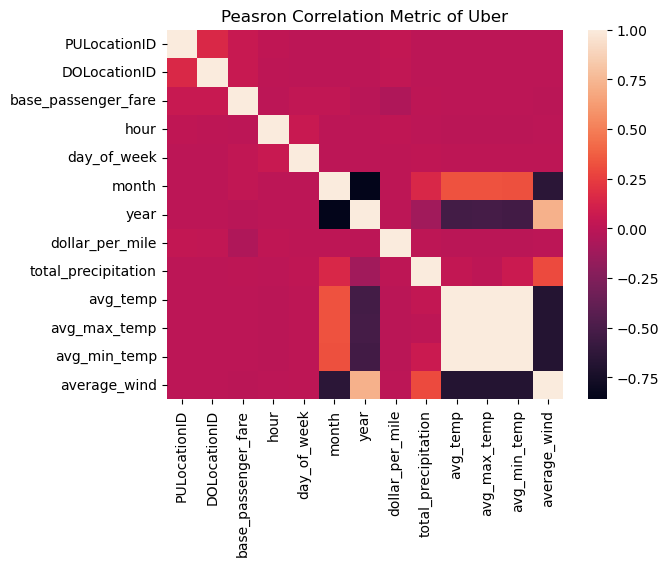

In [4]:
sns.heatmap(uber_sample[CORR_COLS].corr())

plt.title('Peasron Correlation Metric of Uber')
plt.show()

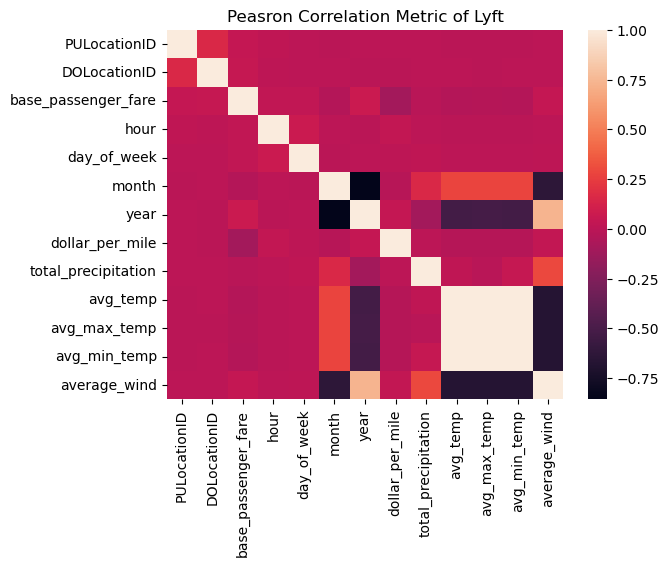

In [5]:
sns.heatmap(lyft_sample[CORR_COLS].corr())

plt.title('Peasron Correlation Metric of Lyft')
plt.show()

## Mapping Uber and Lyft Dominance in NYC by Area
Dominance referring to most number of demand.

In [6]:
# Read the shapefile
shapefile_path = "../data/landing/taxi_zones.shp"
taxi_zones = gpd.read_file(shapefile_path)

In [7]:
# Aggregate trips by PULocationID for Uber
uber_trip_counts = uber_data.groupBy("PULocationID").agg(count("*").alias("trip_count")).withColumn("hvfhs_license_num", lit("Uber"))

# Aggregate trips by PULocationID for Lyft
lyft_trip_counts = lyft_data.groupBy("PULocationID").agg(count("*").alias("trip_count")).withColumn("hvfhs_license_num", lit("Lyft"))

# Convert to Pandas DataFrames for joining with GeoDataFrame
uber_trip_counts_pd = uber_trip_counts.toPandas()
lyft_trip_counts_pd = lyft_trip_counts.toPandas()

In [8]:
# Ensure the columns match for the join operation
uber_trip_counts_pd['LocationID'] = uber_trip_counts_pd['PULocationID']
lyft_trip_counts_pd['LocationID'] = lyft_trip_counts_pd['PULocationID']

# Merge Uber and Lyft trip counts
trip_counts_pd = pd.concat([uber_trip_counts_pd, lyft_trip_counts_pd])

# Pivot the data to have Uber and Lyft counts in separate columns
trip_counts_pivot = trip_counts_pd.pivot_table(index='LocationID', columns='hvfhs_license_num', values='trip_count', fill_value=0)

# Join the pivoted trip data with the taxi zones shapefile data
taxi_zones_trip_counts = taxi_zones.merge(trip_counts_pivot, how='left', left_on='LocationID', right_index=True)

In [9]:
# Determine dominance by comparing trip counts
taxi_zones_trip_counts['dominance'] = taxi_zones_trip_counts.apply(
    lambda row: 'Uber' if row['Uber'] > row['Lyft'] else 'Lyft' if row['Lyft'] > row['Uber'] else 'Equal', axis=1
)

# Count the number of areas dominated by Uber and Lyft
uber_dominant_areas = taxi_zones_trip_counts[taxi_zones_trip_counts['dominance'] == 'Uber'].shape[0]
lyft_dominant_areas = taxi_zones_trip_counts[taxi_zones_trip_counts['dominance'] == 'Lyft'].shape[0]
equal_areas = taxi_zones_trip_counts[taxi_zones_trip_counts['dominance'] == 'Equal'].shape[0]

print(f"Number of areas where Uber dominates: {uber_dominant_areas}")
print(f"Number of areas where Lyft dominates: {lyft_dominant_areas}")
print(f"Number of areas where Uber and Lyft have equal dominance: {equal_areas}")

Number of areas where Uber dominates: 256
Number of areas where Lyft dominates: 3
Number of areas where Uber and Lyft have equal dominance: 4


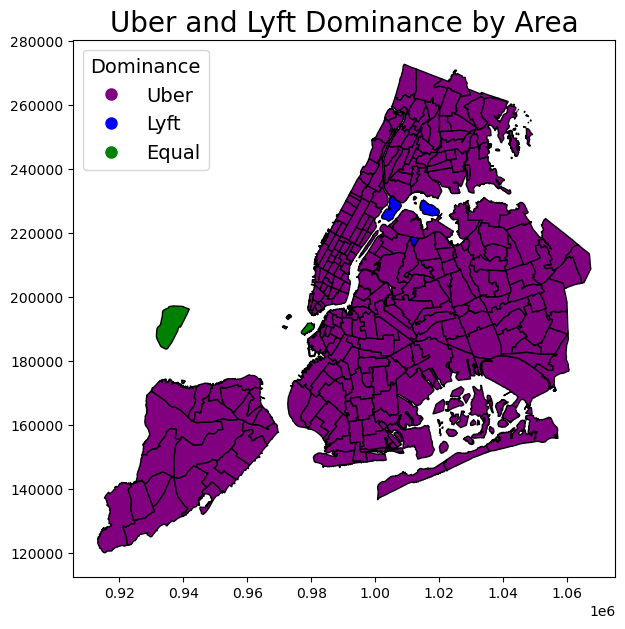

In [10]:
# Create a color map based on dominance
colors = {
    'Uber': 'purple',
    'Lyft': 'blue',
    'Equal': 'green'
}

# Apply the color map to the GeoDataFrame
taxi_zones_trip_counts['color'] = taxi_zones_trip_counts['dominance'].map(colors)

# Plot the map with a smaller figure size and adjusted title font size
fig, ax = plt.subplots(1, 1, figsize=(7, 7))  # Adjusted to make the figure smaller
taxi_zones_trip_counts.plot(ax=ax, color=taxi_zones_trip_counts['color'], edgecolor='black')

# Create a legend with a larger font size
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
           for label, color in colors.items()]
plt.legend(handles=handles, title="Dominance", title_fontsize='14', loc='upper left', bbox_to_anchor=(0, 1), fontsize=14)

# Adjust the title font size
plt.title("Uber and Lyft Dominance by Area", fontsize=20)  # Adjusted title font size

plt.show()


## Trip Counts by Hour of Day
Hours are grouped by pickup hour

In [11]:
# Group by hour
uber_hourly_pd = uber_sample.groupby('hour').size().reset_index(name='uber_trip_count')
lyft_hourly_pd = lyft_sample.groupby('hour').size().reset_index(name='lyft_trip_count')

# Order by hour
uber_hourly_pd = uber_hourly_pd.sort_values('hour')
lyft_hourly_pd = lyft_hourly_pd.sort_values('hour')

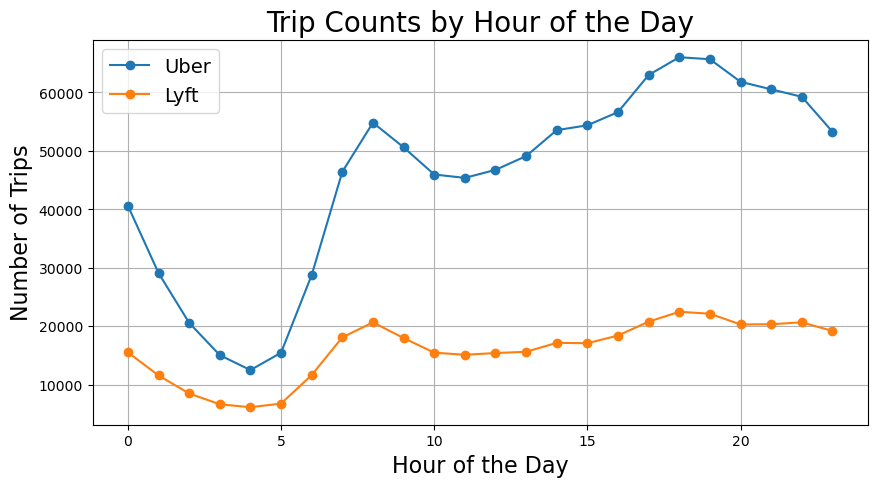

In [12]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(uber_hourly_pd['hour'], uber_hourly_pd['uber_trip_count'], label='Uber', marker='o')
plt.plot(lyft_hourly_pd['hour'], lyft_hourly_pd['lyft_trip_count'], label='Lyft', marker='o')
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)
plt.title('Trip Counts by Hour of the Day', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

## Trip Time Distribution

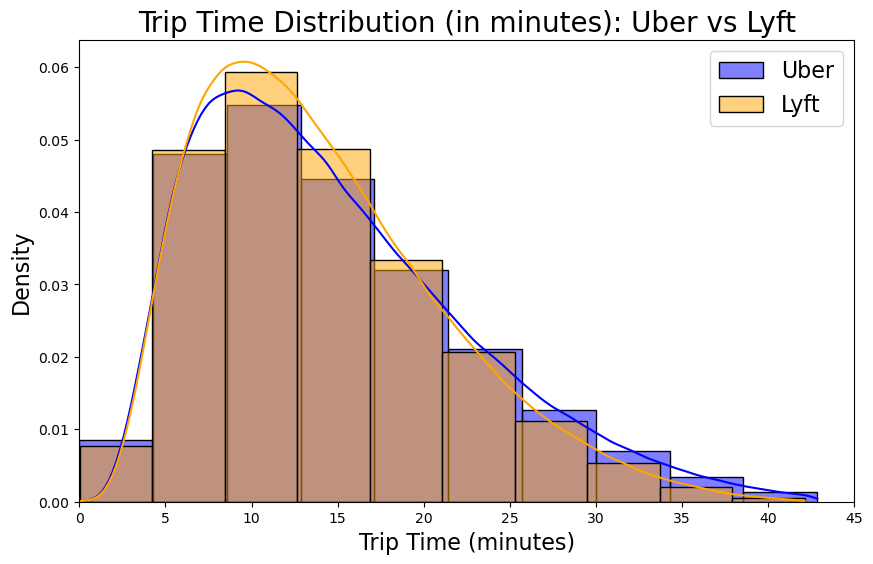

In [13]:
# Convert trip_time to minutes by dividing by 60
uber_sample['trip_time_minutes'] = uber_sample['trip_time'] / 60
lyft_sample['trip_time_minutes'] = lyft_sample['trip_time'] / 60

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot the distribution of trip times for Uber within the specified range in minutes
sns.histplot(uber_sample['trip_time_minutes'], bins=10, kde=True, color='blue', label='Uber', stat="density", alpha=0.5)

# Plot the distribution of trip times for Lyft within the specified range in minutes
sns.histplot(lyft_sample['trip_time_minutes'], bins=10, kde=True, color='orange', label='Lyft', stat="density", alpha=0.5)

# Add titles and labels
plt.xlim(0, 45)
plt.title('Trip Time Distribution (in minutes): Uber vs Lyft', fontsize=20)
plt.xlabel('Trip Time (minutes)', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Add a legend
plt.legend(fontsize=16)

# Show the plot
plt.show()

## Price Distribution

### by Total Price
total price = base_passenger_fare + tolls +  congestion_surcharge + airport_fee

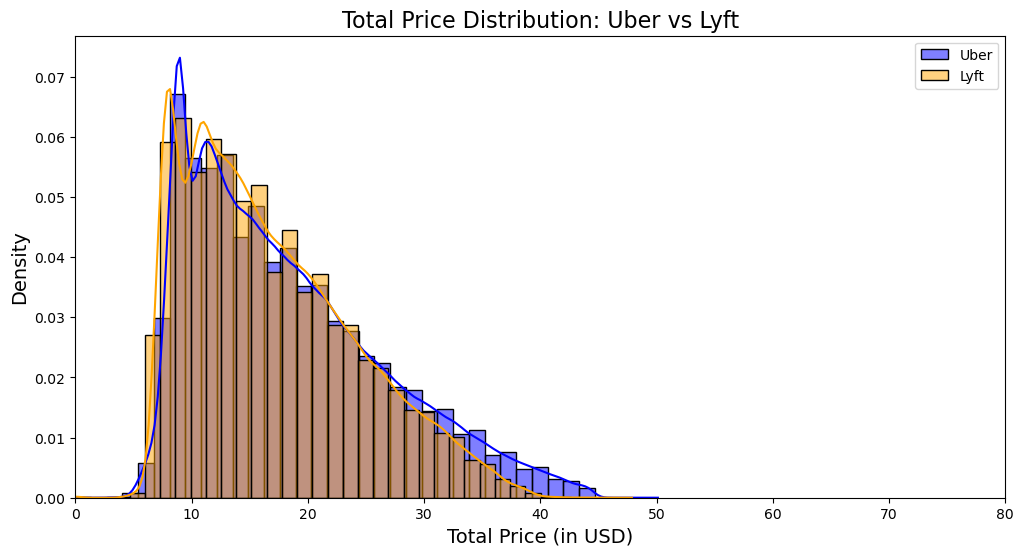

In [14]:
# Create the figure and axes
plt.figure(figsize=(12, 6))

# Plot the distribution of trip times for Uber within the specified range in minutes
sns.histplot(uber_sample['total_price'], bins=40, kde=True, color='blue', label='Uber', stat="density", alpha=0.5)

# Plot the distribution of trip times for Lyft within the specified range in minutes
sns.histplot(lyft_sample['total_price'], bins=40, kde=True, color='orange', label='Lyft', stat="density", alpha=0.5)

# Add titles and labels
plt.xlim(0, 80)
plt.title('Total Price Distribution: Uber vs Lyft', fontsize=16)
plt.xlabel('Total Price (in USD)', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### by Dollar per Mile
dollar per mile = base_passenger_price / trip_miles

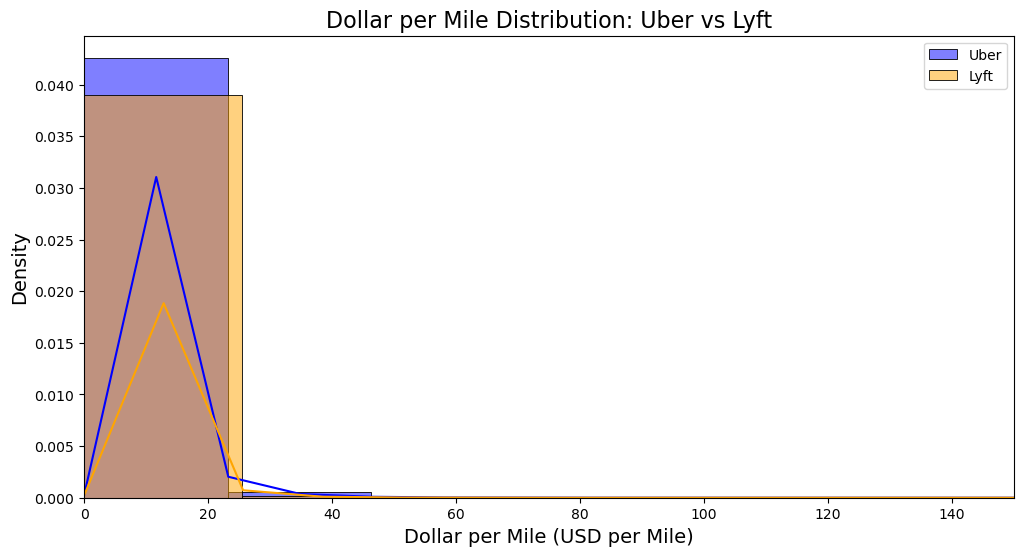

In [15]:
# Create the figure and axes
plt.figure(figsize=(12, 6))

# Plot the distribution of trip times for Uber within the specified range in minutes
sns.histplot(uber_sample['dollar_per_mile'], bins=100, kde=True, color='blue', label='Uber', stat="density", alpha=0.5)

# Plot the distribution of trip times for Lyft within the specified range in minutes
sns.histplot(lyft_sample['dollar_per_mile'], bins=100, kde=True, color='orange', label='Lyft', stat="density", alpha=0.5)

# Add titles and labels
plt.xlim(0,150)
plt.title('Dollar per Mile Distribution: Uber vs Lyft', fontsize=16)
plt.xlabel('Dollar per Mile (USD per Mile)', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [16]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from Uber and Lyft samples
uber_filtered = remove_outliers(uber_sample, 'dollar_per_mile')
lyft_filtered = remove_outliers(lyft_sample, 'dollar_per_mile')

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_19259/596072919.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[uber_filtered['dollar_per_mile'], lyft_filtered['dollar_per_mile']],


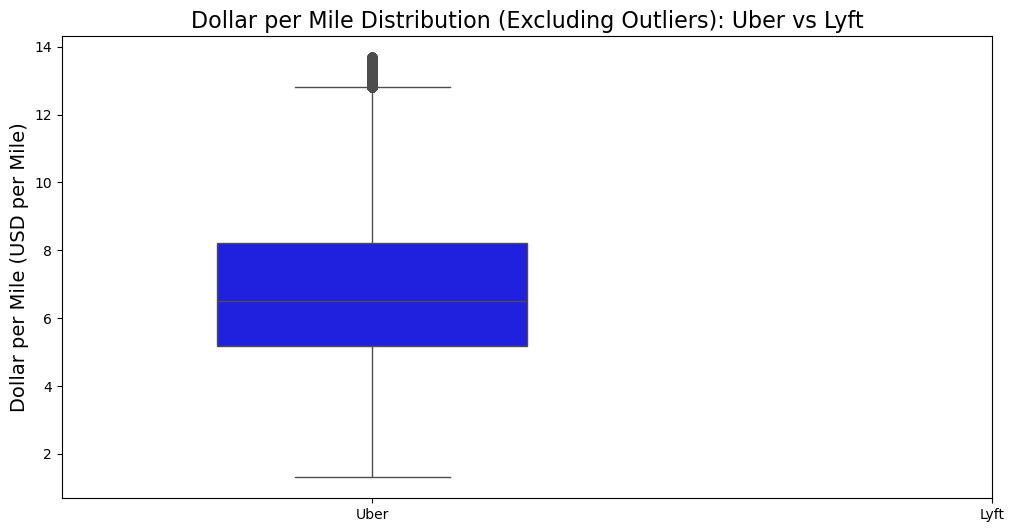

In [17]:
plt.figure(figsize=(12, 6))

# Create a box plot for Uber and Lyft, excluding outliers
sns.boxplot(data=[uber_filtered['dollar_per_mile'], lyft_filtered['dollar_per_mile']],
            palette=['blue', 'orange'], width=0.5)

# Add titles and labels
plt.xticks([0, 1], ['Uber', 'Lyft'])
plt.title('Dollar per Mile Distribution (Excluding Outliers): Uber vs Lyft', fontsize=16)
plt.ylabel('Dollar per Mile (USD per Mile)', fontsize=14)

# Show the plot
plt.show()

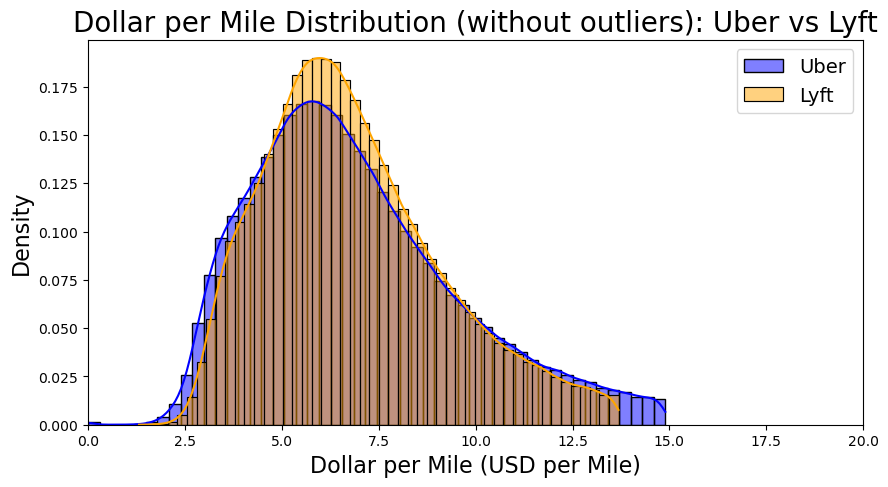

In [18]:
# Create the figure and axes
plt.figure(figsize=(10, 5))

# Plot the distribution of trip times for Uber within the specified range in minutes
sns.histplot(uber_filtered['dollar_per_mile'], bins=50, kde=True, color='blue', label='Uber', stat="density", alpha=0.5)

# Plot the distribution of trip times for Lyft within the specified range in minutes
sns.histplot(lyft_filtered['dollar_per_mile'], bins=50, kde=True, color='orange', label='Lyft', stat="density", alpha=0.5)

# Add titles and labels
plt.xlim(0,20)
plt.title('Dollar per Mile Distribution (without outliers): Uber vs Lyft', fontsize=20)
plt.xlabel('Dollar per Mile (USD per Mile)', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Add a legend
plt.legend(fontsize=14)

# Show the plot
plt.show()

## Demand Seasonality by Seasonal Index
Normalizes demand to ease comparison.

In [19]:
# Aggregate ride counts by year and month for Uber
uber_monthly_demand = uber_sample.groupby(['year', 'month']).size().reset_index(name='ride_count')

# Aggregate ride counts by year and month for Lyft
lyft_monthly_demand = lyft_sample.groupby(['year', 'month']).size().reset_index(name='ride_count')

# Combine year and month into a single column for easier plotting
uber_monthly_demand['date'] = pd.to_datetime(uber_monthly_demand[['year', 'month']].assign(day=1))
lyft_monthly_demand['date'] = pd.to_datetime(lyft_monthly_demand[['year', 'month']].assign(day=1))


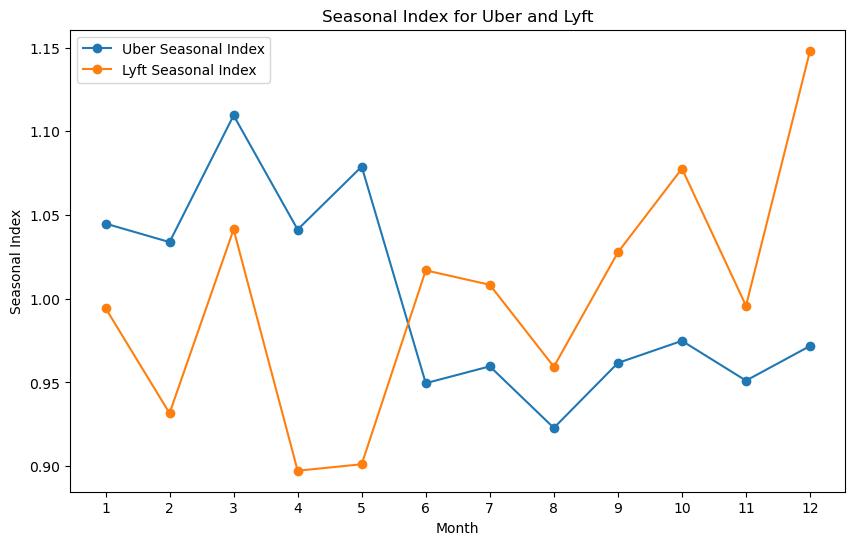

In [20]:
# Calculate monthly averages
uber_monthly_avg = uber_monthly_demand.groupby(uber_monthly_demand['date'].dt.month)['ride_count'].mean()
lyft_monthly_avg = lyft_monthly_demand.groupby(lyft_monthly_demand['date'].dt.month)['ride_count'].mean()

# Calculate overall averages
uber_overall_avg = uber_monthly_demand['ride_count'].mean()
lyft_overall_avg = lyft_monthly_demand['ride_count'].mean()

# Calculate seasonal indexes
uber_seasonal_index = uber_monthly_avg / uber_overall_avg
lyft_seasonal_index = lyft_monthly_avg / lyft_overall_avg

# Plot the seasonal indexes
plt.figure(figsize=(10, 6))
plt.plot(uber_seasonal_index, label='Uber Seasonal Index', marker='o')
plt.plot(lyft_seasonal_index, label='Lyft Seasonal Index', marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Seasonal Index')
plt.title('Seasonal Index for Uber and Lyft')
plt.legend()
plt.show()


## Average Temp vs Demand

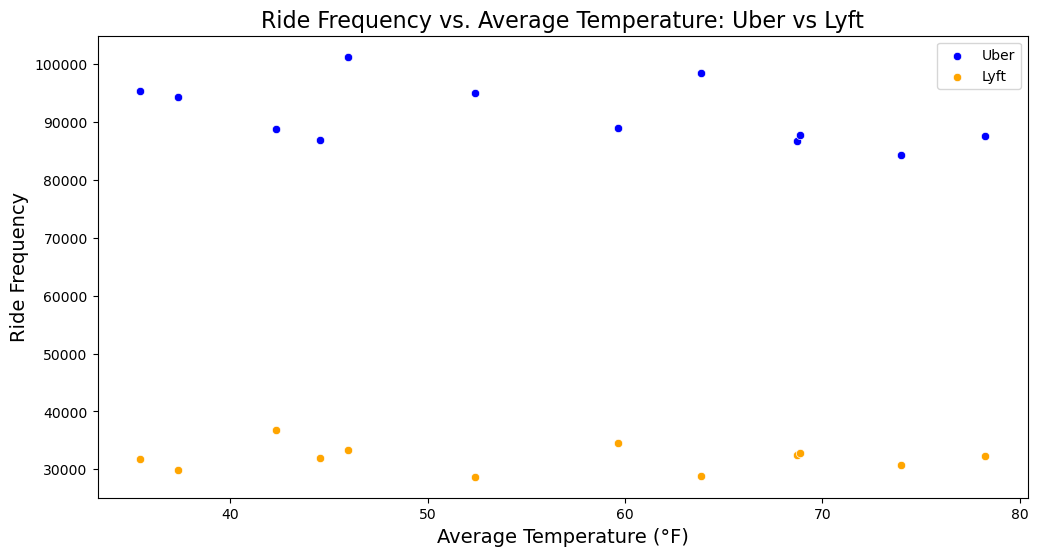

In [21]:
uber_temp_freq = uber_sample.groupby('avg_temp').size().reset_index(name='ride_frequency')
lyft_temp_freq = lyft_sample.groupby('avg_temp').size().reset_index(name='ride_frequency')

plt.figure(figsize=(12, 6))

sns.scatterplot(x='avg_temp', y='ride_frequency', data=uber_temp_freq, label='Uber', color='blue')
sns.scatterplot(x='avg_temp', y='ride_frequency', data=lyft_temp_freq, label='Lyft', color='orange')

plt.title('Ride Frequency vs. Average Temperature: Uber vs Lyft', fontsize=16)
plt.xlabel('Average Temperature (°F)', fontsize=14)
plt.ylabel('Ride Frequency', fontsize=14)

plt.legend()

plt.show()

## Precipitation vs Demand

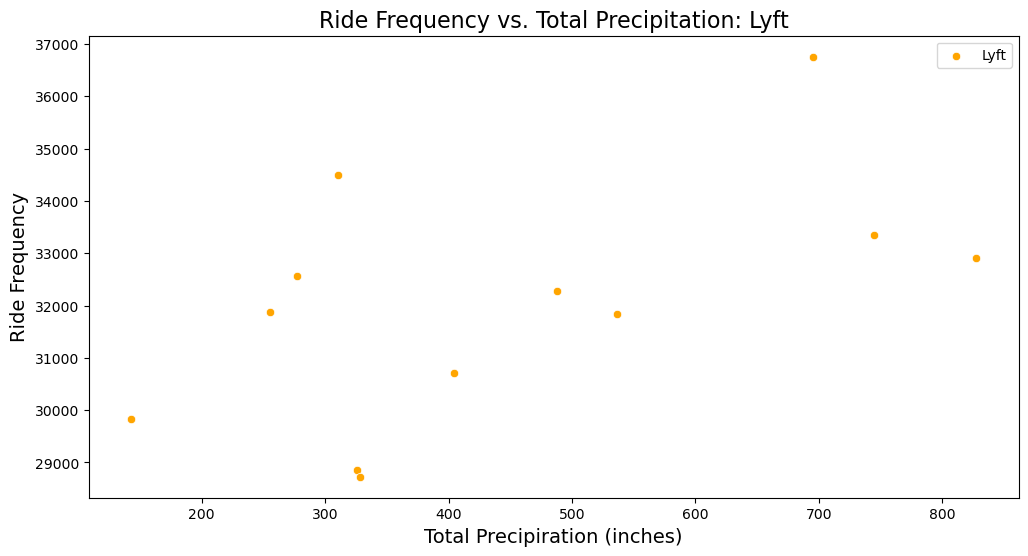

In [22]:
uber_prec_freq = uber_sample.groupby('total_precipitation').size().reset_index(name='ride_frequency')
lyft_prec_freq = lyft_sample.groupby('total_precipitation').size().reset_index(name='ride_frequency')

plt.figure(figsize=(12, 6))

#sns.scatterplot(x='total_precipitation', y='ride_frequency', data=uber_prec_freq, label='Uber', color='blue')
sns.scatterplot(x='total_precipitation', y='ride_frequency', data=lyft_prec_freq, label='Lyft', color='orange')

plt.title('Ride Frequency vs. Total Precipitation: Lyft', fontsize=16)
plt.xlabel('Total Precipiration (inches)', fontsize=14)
plt.ylabel('Ride Frequency', fontsize=14)

plt.legend()

plt.show()

## Average Max Temp vs. Demand

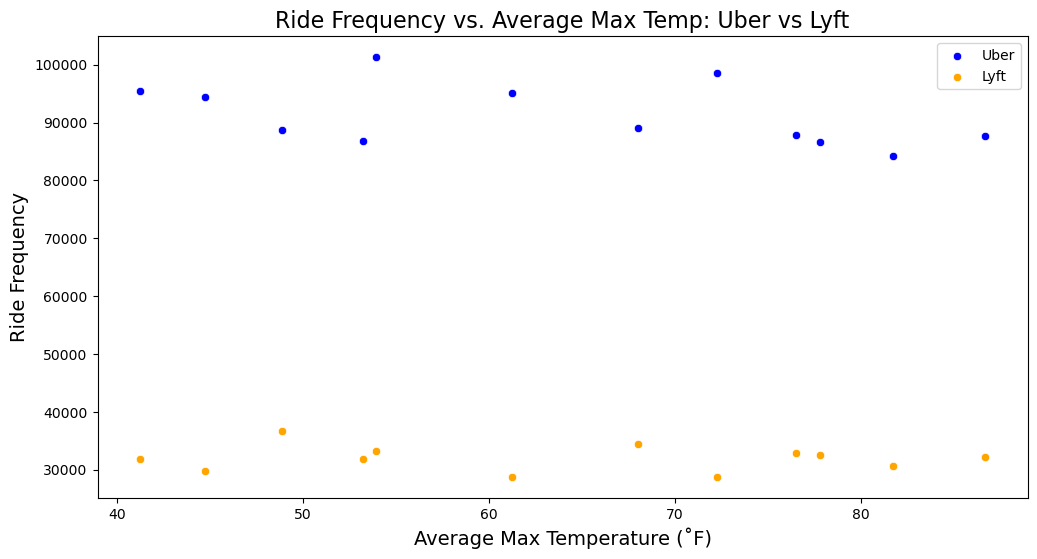

In [23]:
uber_maxt_freq = uber_sample.groupby('avg_max_temp').size().reset_index(name='ride_frequency')
lyft_maxt_freq = lyft_sample.groupby('avg_max_temp').size().reset_index(name='ride_frequency')

plt.figure(figsize=(12, 6))

sns.scatterplot(x='avg_max_temp', y='ride_frequency', data=uber_maxt_freq, label='Uber', color='blue')
sns.scatterplot(x='avg_max_temp', y='ride_frequency', data=lyft_maxt_freq, label='Lyft', color='orange')

plt.title('Ride Frequency vs. Average Max Temp: Uber vs Lyft', fontsize=16)
plt.xlabel('Average Max Temperature (˚F)', fontsize=14)
plt.ylabel('Ride Frequency', fontsize=14)

plt.legend()

plt.show()

## Average Wind vs Demand

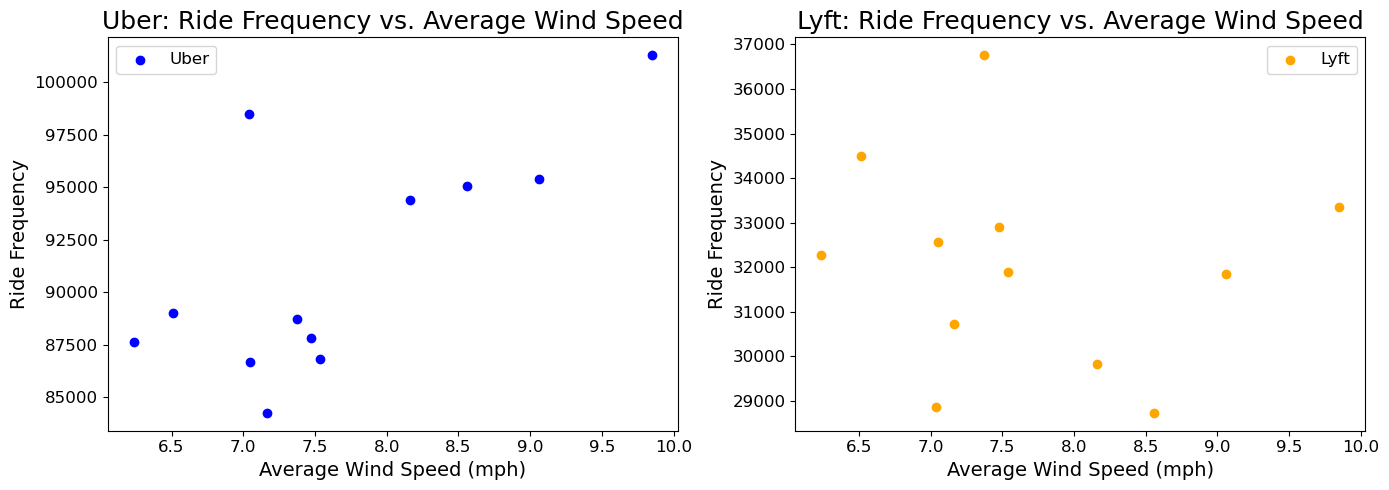

In [24]:
# Group by 'average_wind' for both Uber and Lyft
uber_wind_freq = uber_sample.groupby('average_wind').size().reset_index(name='ride_frequency')
lyft_wind_freq = lyft_sample.groupby('average_wind').size().reset_index(name='ride_frequency')

# Convert the grouped data to pandas DataFrame for plotting
uber_wind_freq_pd = uber_wind_freq
lyft_wind_freq_pd = lyft_wind_freq

# Define padding for x and y axis limits
padding = 0.05  # 5% padding

# Calculate the x and y limits with padding for Uber
uber_x_min, uber_x_max = uber_wind_freq_pd['average_wind'].min(), uber_wind_freq_pd['average_wind'].max()
uber_y_min, uber_y_max = uber_wind_freq_pd['ride_frequency'].min(), uber_wind_freq_pd['ride_frequency'].max()

uber_x_range = uber_x_max - uber_x_min
uber_y_range = uber_y_max - uber_y_min

# Calculate the x and y limits with padding for Lyft
lyft_x_min, lyft_x_max = lyft_wind_freq_pd['average_wind'].min(), lyft_wind_freq_pd['average_wind'].max()
lyft_y_min, lyft_y_max = lyft_wind_freq_pd['ride_frequency'].min(), lyft_wind_freq_pd['ride_frequency'].max()

lyft_x_range = lyft_x_max - lyft_x_min
lyft_y_range = lyft_y_max - lyft_y_min

# Font size configuration
title_fontsize = 18
label_fontsize = 14
tick_fontsize = 12
legend_fontsize = 12

# Plot the results
plt.figure(figsize=(14, 5))

# Plot Uber ride frequency vs average wind speed
plt.subplot(1, 2, 1)
plt.scatter(uber_wind_freq_pd['average_wind'], uber_wind_freq_pd['ride_frequency'], color='blue', label='Uber')
plt.title('Uber: Ride Frequency vs. Average Wind Speed', fontsize=title_fontsize)
plt.xlabel('Average Wind Speed (mph)', fontsize=label_fontsize)
plt.ylabel('Ride Frequency', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.xlim([uber_x_min - padding * uber_x_range, uber_x_max + padding * uber_x_range])
plt.ylim([uber_y_min - padding * uber_y_range, uber_y_max + padding * uber_y_range])
plt.legend(fontsize=legend_fontsize)

# Plot Lyft ride frequency vs average wind speed
plt.subplot(1, 2, 2)
plt.scatter(lyft_wind_freq_pd['average_wind'], lyft_wind_freq_pd['ride_frequency'], color='orange', label='Lyft')
plt.title('Lyft: Ride Frequency vs. Average Wind Speed', fontsize=title_fontsize)
plt.xlabel('Average Wind Speed (mph)', fontsize=label_fontsize)
plt.ylabel('Ride Frequency', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.xlim([lyft_x_min - padding * lyft_x_range, lyft_x_max + padding * lyft_x_range])
plt.ylim([lyft_y_min - padding * lyft_y_range, lyft_y_max + padding * lyft_y_range])
plt.legend(fontsize=legend_fontsize)

plt.tight_layout()
plt.show()


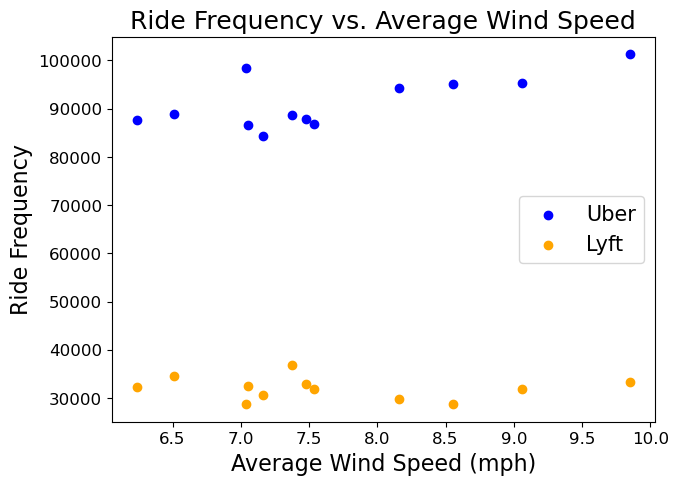

In [25]:
# Group by 'average_wind' for both Uber and Lyft
uber_wind_freq = uber_sample.groupby('average_wind').size().reset_index(name='ride_frequency')
lyft_wind_freq = lyft_sample.groupby('average_wind').size().reset_index(name='ride_frequency')

# Convert the grouped data to pandas DataFrame for plotting
uber_wind_freq_pd = uber_wind_freq
lyft_wind_freq_pd = lyft_wind_freq

# Define padding for x and y axis limits
padding = 0.05  # 5% padding

# Calculate the x and y limits with padding for Uber
uber_x_min, uber_x_max = uber_wind_freq_pd['average_wind'].min(), uber_wind_freq_pd['average_wind'].max()
uber_y_min, uber_y_max = uber_wind_freq_pd['ride_frequency'].min(), uber_wind_freq_pd['ride_frequency'].max()

uber_x_range = uber_x_max - uber_x_min
uber_y_range = uber_y_max - uber_y_min

# Calculate the x and y limits with padding for Lyft
lyft_x_min, lyft_x_max = lyft_wind_freq_pd['average_wind'].min(), lyft_wind_freq_pd['average_wind'].max()
lyft_y_min, lyft_y_max = lyft_wind_freq_pd['ride_frequency'].min(), lyft_wind_freq_pd['ride_frequency'].max()

lyft_x_range = lyft_x_max - lyft_x_min
lyft_y_range = lyft_y_max - lyft_y_min

# Font size configuration
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 12
legend_fontsize = 15

# Plot the results
plt.figure(figsize=(7, 5))

plt.scatter(uber_wind_freq_pd['average_wind'], uber_wind_freq_pd['ride_frequency'], color='blue', label='Uber')
plt.scatter(lyft_wind_freq_pd['average_wind'], lyft_wind_freq_pd['ride_frequency'], color='orange', label='Lyft')
plt.title('Ride Frequency vs. Average Wind Speed', fontsize=title_fontsize)
plt.xlabel('Average Wind Speed (mph)', fontsize=label_fontsize)
plt.ylabel('Ride Frequency', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.show()


## Weekday vs Demand

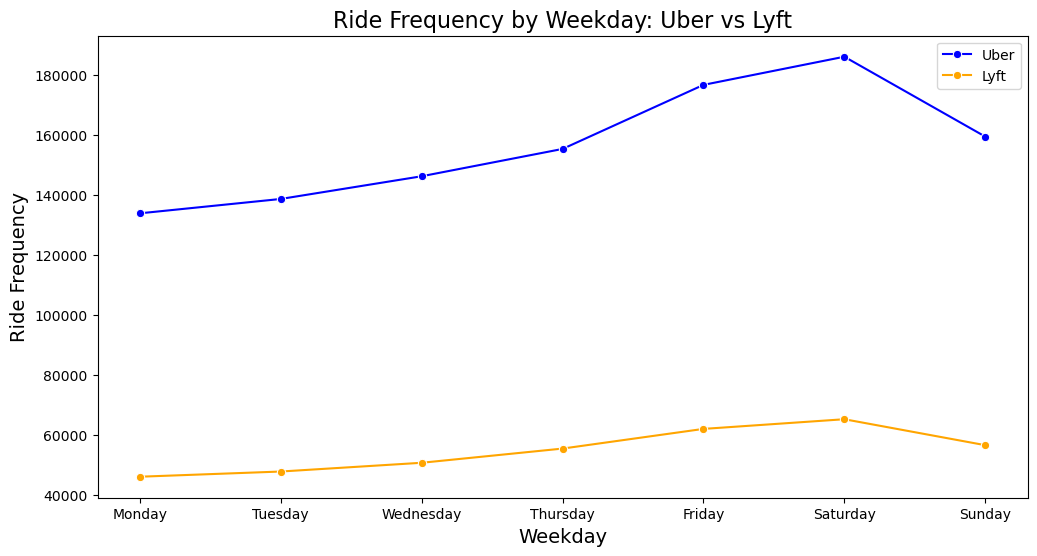

24/08/24 00:47:21 WARN TransportChannelHandler: Exception in connection from /192.168.0.3:53817
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimiz

In [26]:
uber_sample['weekday'] = uber_sample['pickup_datetime'].dt.day_name()
lyft_sample['weekday'] = lyft_sample['pickup_datetime'].dt.day_name()

# Step 2: Group by weekday and calculate ride frequency
# For Uber
uber_weekday_freq = uber_sample.groupby('weekday').size().reset_index(name='ride_frequency')

# For Lyft
lyft_weekday_freq = lyft_sample.groupby('weekday').size().reset_index(name='ride_frequency')

# To ensure the days are in order from Monday to Sunday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
uber_weekday_freq['weekday'] = pd.Categorical(uber_weekday_freq['weekday'], categories=days_order, ordered=True)
lyft_weekday_freq['weekday'] = pd.Categorical(lyft_weekday_freq['weekday'], categories=days_order, ordered=True)

plt.figure(figsize=(12, 6))

# Line plot for Uber
sns.lineplot(x='weekday', y='ride_frequency', data=uber_weekday_freq, label='Uber', marker='o', color='blue')

# Line plot for Lyft
sns.lineplot(x='weekday', y='ride_frequency', data=lyft_weekday_freq, label='Lyft', marker='o', color='orange')

# Add titles and labels
plt.title('Ride Frequency by Weekday: Uber vs Lyft', fontsize=16)
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Ride Frequency', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.show()